# Rossmann Store Sales Prediction - Part 2: Preprocessing

This notebook focuses on preprocessing the Rossmann store sales data for prediction. It implement various feature engineering techniques to prepare the data for machine learning models.


## Objective
The goal is to preprocess the data to predict daily sales for various Rossmann stores up to 6 weeks ahead. This involves:
- Converting non-numeric columns to numeric
- Handling missing values
- Generating new features from existing ones
- Scaling the data for machine learning models

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# Add src to path for importing custom modules
sys.path.append('..')

# Import custom modules
from src.data.data_loader import RossmannDataLoader
from src.preprocessing.feature_engineering import RossmannFeatureEngineer

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

sns.set_palette('husl')

## 1. Setup and Data Loading
First, load the training and test data using the RossmannDataLoader class.

In [2]:
# Initialize data loader
data_loader = RossmannDataLoader()

# Load data
train_df, test_df = data_loader.load_data()
store_df = data_loader.load_store_data()

# Merge store data
train_df = data_loader.merge_store_data(train_df, store_df)
test_df = data_loader.merge_store_data(test_df, store_df)

print(f"Training data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")

c:\Users\hp\Desktop\rossmann-sales-prediction\notebooks\..\src\data\data_loader.py:52: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_path, parse_dates=['Date'])


Training data shape: (1017209, 18)
Test data shape: (41088, 17)


## 2. Feature Engineering
  use the RossmannFeatureEngineer class to create various features from the data. examine each feature group separately.

In [3]:
# Initialize feature engineer
feature_engineer = RossmannFeatureEngineer()

# Extract datetime features
train_with_date = feature_engineer.extract_datetime_features(train_df)

# Display new datetime features
datetime_features = ['Year', 'Month', 'Day', 'WeekOfYear', 'DayOfWeek', 'IsWeekend',
                     'IsMonthStart', 'IsMonthEnd', 'IsMidMonth', 'Quarter', 'Season']
print("\nSample of datetime features:")
display(train_with_date[['Date'] + datetime_features].head())


Sample of datetime features:


,Date,Year,Month,Day,WeekOfYear,DayOfWeek,IsWeekend,IsMonthStart,IsMonthEnd,IsMidMonth,Quarter,Season
0,2015-07-31,2015,7,31,31,4,0,0,1,0,3,2
1,2015-07-31,2015,7,31,31,4,0,0,1,0,3,2
2,2015-07-31,2015,7,31,31,4,0,0,1,0,3,2
3,2015-07-31,2015,7,31,31,4,0,0,1,0,3,2
4,2015-07-31,2015,7,31,31,4,0,0,1,0,3,2



Sample of holiday features:


,StateHoliday,IsHoliday,DaysToHoliday,DaysAfterHoliday
0,0,0,0,57
1,0,0,0,67
2,0,0,0,57
3,0,0,0,67
4,0,0,0,57


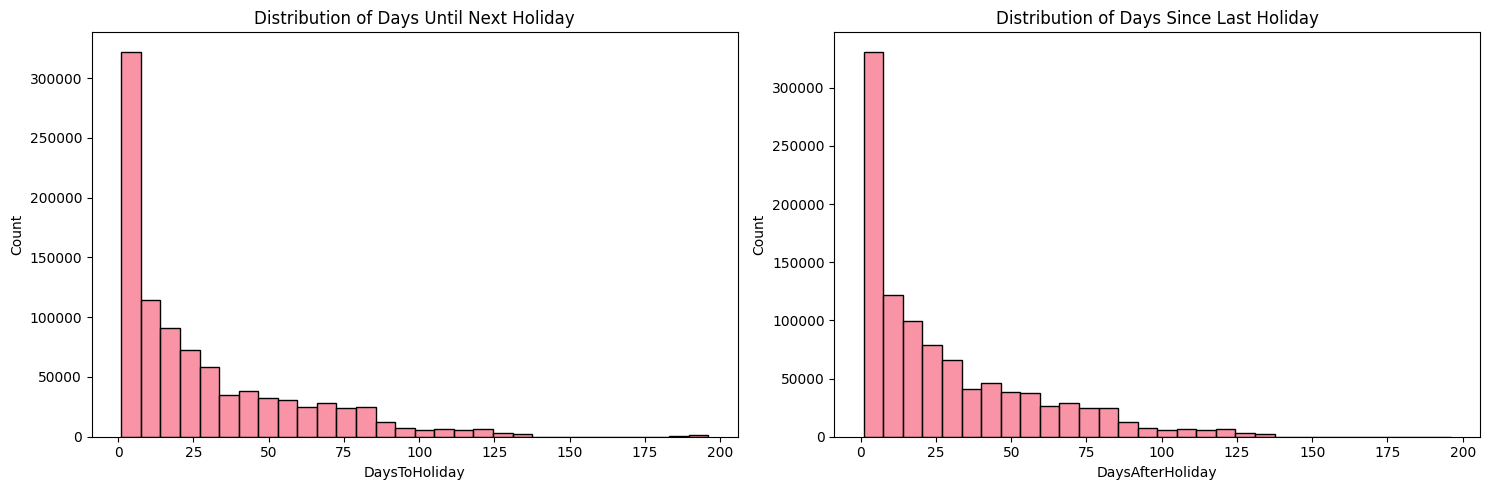

In [4]:
# Calculate holiday distances
train_with_holidays = feature_engineer.calculate_holiday_distances(train_with_date)

# Display holiday-related features
holiday_features = ['StateHoliday', 'IsHoliday', 'DaysToHoliday', 'DaysAfterHoliday']
print("\nSample of holiday features:")
display(train_with_holidays[holiday_features].head())

# Visualize distribution of days to/from holidays
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=train_with_holidays[train_with_holidays['DaysToHoliday'] > 0],
             x='DaysToHoliday', bins=30, ax=ax1)
ax1.set_title('Distribution of Days Until Next Holiday')

sns.histplot(data=train_with_holidays[train_with_holidays['DaysAfterHoliday'] > 0],
             x='DaysAfterHoliday', bins=30, ax=ax2)
ax2.set_title('Distribution of Days Since Last Holiday')

plt.tight_layout()
plt.show()


Sample of competition features:


,CompetitionOpen,CompetitionDuration,CompetitionDistanceCategory
0,82.0,3,1
1,92.0,3,0
2,103.0,3,3
3,70.0,3,0
4,3.0,1,3


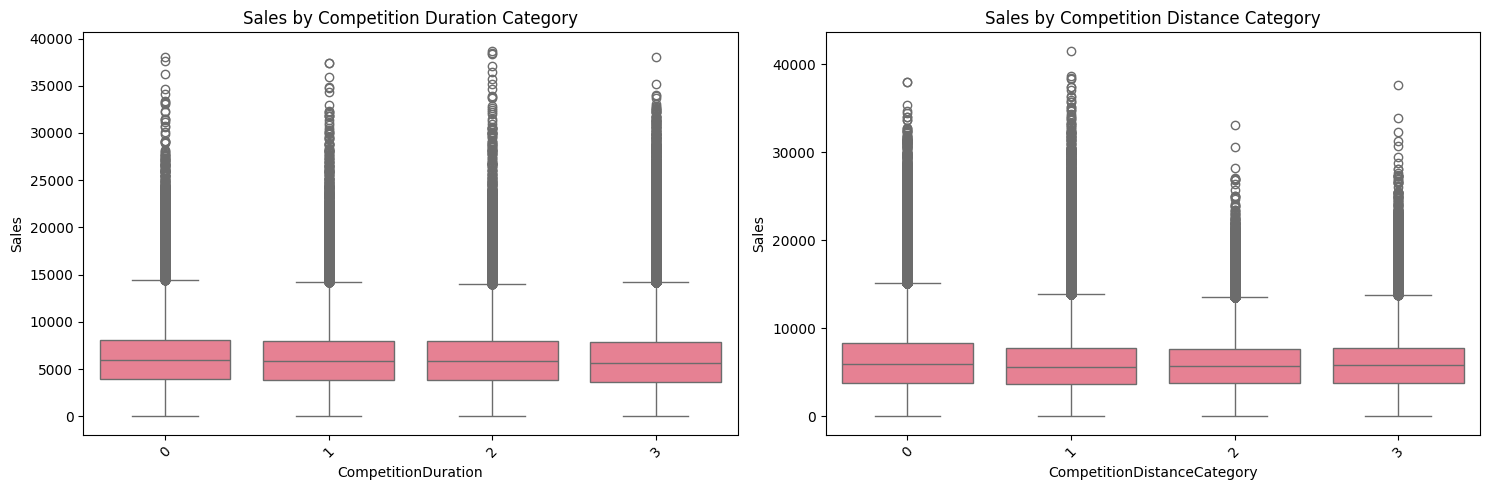

In [5]:
# Create competition features
train_with_competition = feature_engineer.create_competition_features(train_with_holidays)

# Display competition-related features
competition_features = ['CompetitionOpen', 'CompetitionDuration', 'CompetitionDistanceCategory']
print("\nSample of competition features:")
display(train_with_competition[competition_features].head())

# Visualize relationship between competition features and sales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=train_with_competition, x='CompetitionDuration', y='Sales', ax=ax1)
ax1.set_title('Sales by Competition Duration Category')
ax1.tick_params(axis='x', rotation=45)

sns.boxplot(data=train_with_competition, x='CompetitionDistanceCategory', y='Sales', ax=ax2)
ax2.set_title('Sales by Competition Distance Category')
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


Sample of promotion features:


,Promo,Promo2,Promo2Open,IsPromoMonth
0,1,0,<NA>,0
1,1,1,64.5,1
2,1,1,52.25,1
3,1,0,<NA>,0
4,1,0,<NA>,0


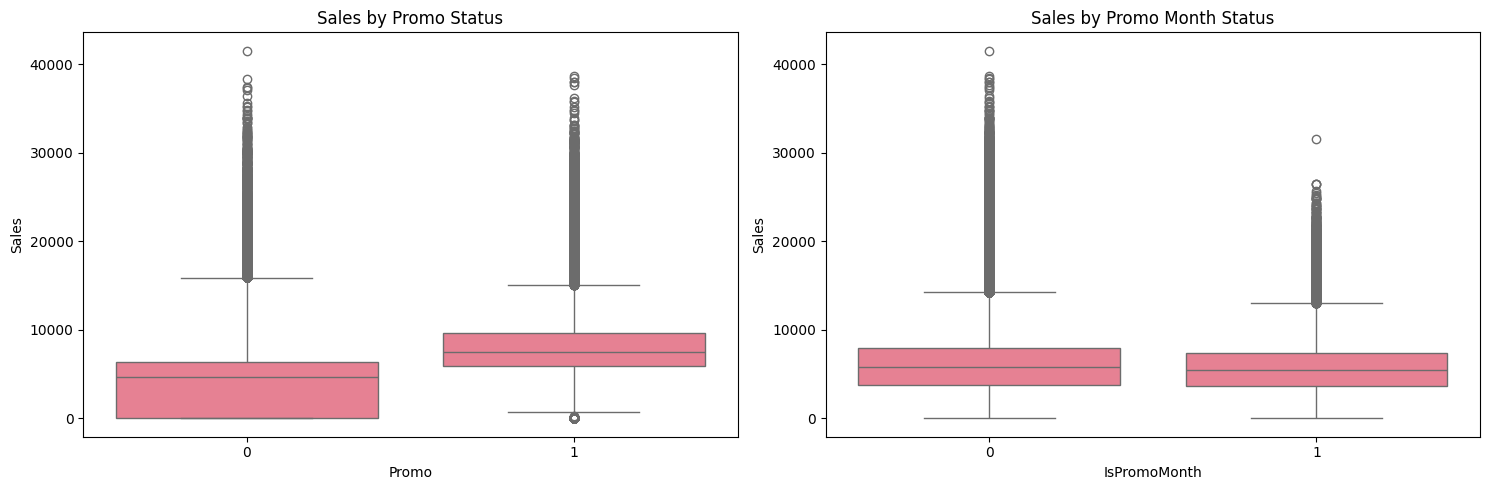

In [6]:
# Create promotion features
train_with_promo = feature_engineer.create_promo_features(train_with_competition)

# Display promotion-related features
promo_features = ['Promo', 'Promo2', 'Promo2Open', 'IsPromoMonth']
print("\nSample of promotion features:")
display(train_with_promo[promo_features].head())

# Visualize impact of promotions on sales
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=train_with_promo, x='Promo', y='Sales', ax=ax1)
ax1.set_title('Sales by Promo Status')

sns.boxplot(data=train_with_promo, x='IsPromoMonth', y='Sales', ax=ax2)
ax2.set_title('Sales by Promo Month Status')

plt.tight_layout()
plt.show()

## 3. Data Preprocessing
Now apply the complete preprocessing pipeline to prepare the data for modeling.

In [7]:
# Apply full preprocessing pipeline
train_processed, test_processed = feature_engineer.preprocess_data(train_df, test_df)

print("\nProcessed training data info:")
train_processed.info()

print("\nProcessed test data info:")
test_processed.info()


Processed training data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 37 columns):
 #   Column                       Non-Null Count    Dtype         
---  ------                       --------------    -----         
 0   Store                        1017209 non-null  int64         
 1   DayOfWeek                    1017209 non-null  int32         
 2   Date                         1017209 non-null  datetime64[ns]
 3   Sales                        1017209 non-null  int64         
 4   Customers                    1017209 non-null  int64         
 5   Open                         1017209 non-null  int64         
 6   Promo                        1017209 non-null  int64         
 7   StateHoliday                 886137 non-null   float64       
 8   SchoolHoliday                1017209 non-null  int64         
 9   StoreType                    1017209 non-null  int64         
 10  Assortment                   1017209 non-null  

## 4. Preprocessed Data Analysis
analyze the preprocessed data to ensure it's ready for modeling.

In [8]:
# Check for missing values
print("Missing values in training data:")
display(train_processed.isnull().sum()[train_processed.isnull().sum() > 0])

print("\nMissing values in test data:")
display(test_processed.isnull().sum()[test_processed.isnull().sum() > 0])

Missing values in training data:


StateHoliday                 131072
CompetitionDistance            2642
CompetitionOpenSinceMonth    323348
CompetitionOpenSinceYear     323348
Promo2SinceWeek              508031
Promo2SinceYear              508031
PromoInterval                508031
CompetitionOpen              323348
CompetitionDuration          323348
Promo2Open                   508031
dtype: int64


Missing values in test data:


Open                            11
CompetitionDistance             96
CompetitionOpenSinceMonth    15216
CompetitionOpenSinceYear     15216
Promo2SinceWeek              17232
Promo2SinceYear              17232
PromoInterval                17232
CompetitionOpen              15216
CompetitionDuration          15216
Promo2Open                   17232
dtype: int64

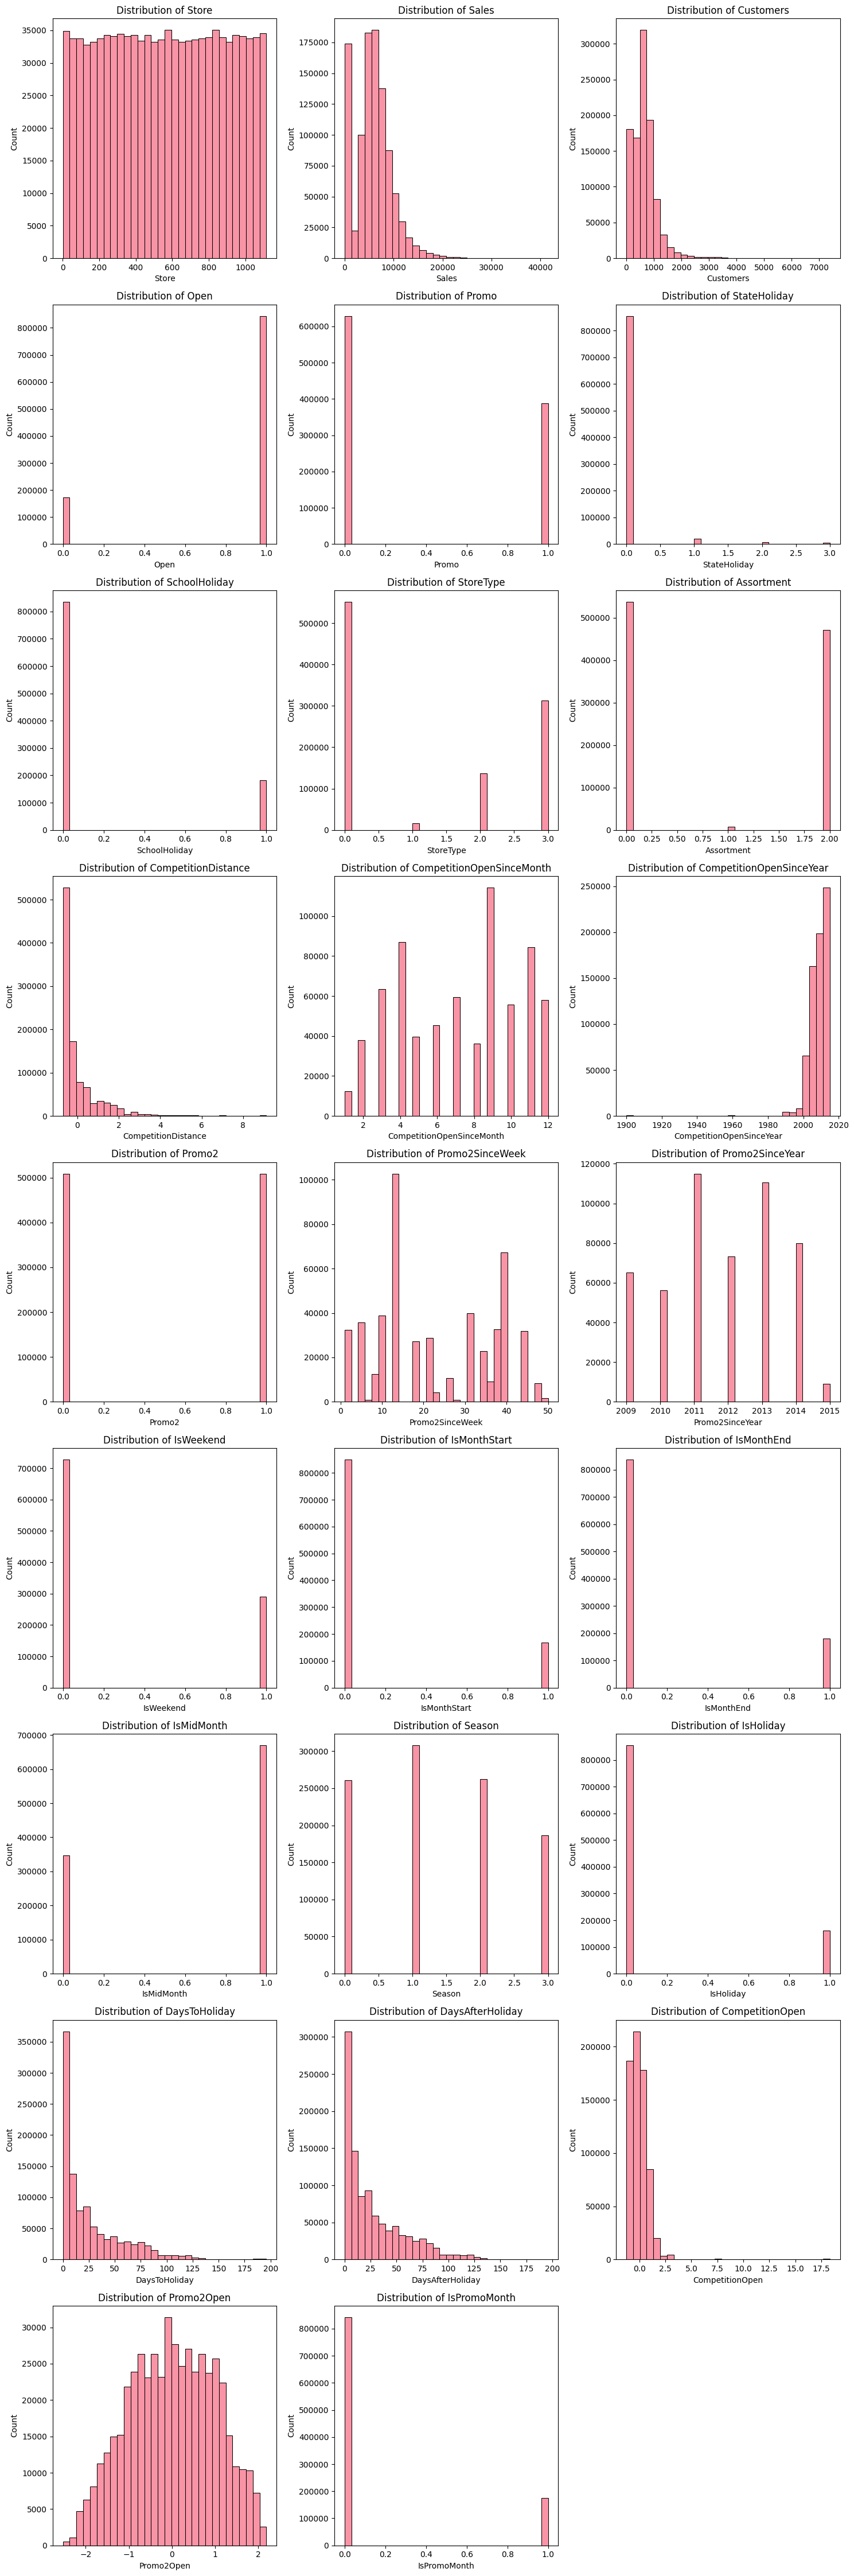

In [9]:
# Analyze feature distributions
numerical_features = train_processed.select_dtypes(include=['float64', 'int64']).columns
n_features = len(numerical_features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(data=train_processed, x=feature, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution of {feature}')

# Hide empty subplots
for i in range(n_features, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

In [10]:
# Save preprocessed data
output_dir = Path('../data/processed')
output_dir.mkdir(parents=True, exist_ok=True)

train_processed.to_csv(output_dir / 'train_processed.csv', index=False)
test_processed.to_csv(output_dir / 'test_processed.csv', index=False)

print("Preprocessed data saved to 'data/processed' directory")

Preprocessed data saved to 'data/processed' directory


## Summary of Preprocessing Steps

We have successfully preprocessed our data by:

1. **DateTime Features**:
   - Extracted year, month, day, week of year
   - Created weekend indicator
   - Added month period indicators (start, mid, end)
   - Added quarter and season information

2. **Holiday Features**:
   - Calculated days until next holiday
   - Calculated days since last holiday
   - Created holiday indicator

3. **Competition Features**:
   - Calculated competition duration
   - Created competition duration categories
   - Created competition distance categories

4. **Promotion Features**:
   - Calculated promotion duration
   - Created promotion month indicator

5. **Categorical Encoding**:
   - Encoded store type
   - Encoded assortment type
   - Encoded state holiday

6. **Feature Scaling**:
   - Applied standard scaling to numerical features

The preprocessed data is now ready for model development in the next notebook.